In [1]:
###################################
##  Written by Ishara Fernando   ##
##  Revised Date: 01/15/2024     ##
###################################


import numpy as np
import pandas as pd
import tensorflow as tf
from BHDVCS_tf_modified import *
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import sys


def create_folders(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully!")
    else:
        print(f"Folder '{folder_name}' already exists!")
        

create_folders('DNNmodels')
create_folders('Losses_CSVs')
create_folders('Losses_Plots')
create_folders('Replica_Data')
create_folders('Replica_Results')
create_folders('Comparison_Plots')
create_folders('Projections_for_Improve_Model')

data_file = 'PseudoData_from_the_Basic_Model_for_JLab_Kinematics.csv'
grid_file = 'grid_data.csv'
df = pd.read_csv(data_file, dtype=np.float64)
df = df.rename(columns={"sigmaF": "errF"})
grid_df = pd.read_csv(grid_file, dtype=np.float64)

Folder 'DNNmodels' created successfully!
Folder 'Losses_CSVs' created successfully!
Folder 'Losses_Plots' created successfully!
Folder 'Replica_Data' created successfully!
Folder 'Replica_Results' created successfully!
Folder 'Comparison_Plots' created successfully!
Folder 'Projections_for_Improve_Model' created successfully!


In [2]:
#### User's inputs ####
Learning_Rate = 0.0001
EPOCHS = 100
EarlyStop_patience = 1000
modify_LR_patience = 400
modify_LR_factor = 0.9

modify_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=modify_LR_factor,patience=modify_LR_patience,mode='auto')
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=EarlyStop_patience)
NUM_REPLICAS = 2

def chisquare(y, yhat, err):
    return np.sum(((y - yhat)/err)**2)

def split_data(X,y,yerr,split=0.1):
  temp =np.random.choice(list(range(len(y))), size=int(len(y)*split), replace = False)

  test_X = pd.DataFrame.from_dict({k: v[temp] for k,v in X.items()})
  train_X = pd.DataFrame.from_dict({k: v.drop(temp) for k,v in X.items()})

  test_y = y[temp]
  train_y = y.drop(temp)

  test_yerr = yerr[temp]
  train_yerr = yerr.drop(temp)

  return train_X, test_X, train_y, test_y, train_yerr, test_yerr


In [3]:
####### Here we define a function that can sample F within sigmaF ###
def GenerateReplicaData(df):
    pseudodata_df = {'k': [],
                     'QQ': [],
                     'x_b': [],
                     't': [],
                     'phi_x': [],
                     'F':[],
                     'errF':[]}
    #pseudodata_df = pd.DataFrame(pseudodata_df)
    pseudodata_df['k'] = df['k']
    pseudodata_df['QQ'] = df['QQ']
    pseudodata_df['x_b'] = df['x_b']
    pseudodata_df['t'] = df['t']
    pseudodata_df['phi_x']= df['phi_x']
    pseudodata_df['errF']= df['errF']
    pseudodata_df['dvcs']= df['dvcs']
    tempF = np.array(df['F'])
    tempFerr = np.abs(np.array(df['errF'])) ## Had to do abs due to a run-time error
    ReplicaF = np.random.normal(loc=tempF, scale=tempFerr)
    pseudodata_df['F']=ReplicaF
    return pd.DataFrame(pseudodata_df)

In [4]:
def DNNmodel():
    initializer = tf.keras.initializers.RandomUniform(minval=-0.1,maxval=0.1,seed=None)
    #### QQ, x_b, t, phi, k ####
    inputs = tf.keras.Input(shape=(5), name='input_layer')
    QQ, x_b, t, phi, k = tf.split(inputs, num_or_size_splits=5, axis=1)
    kinematics = tf.keras.layers.concatenate([QQ, x_b, t])
    x1 = tf.keras.layers.Dense(100, activation="tanh", kernel_initializer=initializer)(kinematics)
    x2 = tf.keras.layers.Dense(100, activation="tanh", kernel_initializer=initializer)(x1)
    outputs = tf.keras.layers.Dense(4, activation="linear", kernel_initializer=initializer, name='cff_output_layer')(x2)
    #### QQ, x_b, t, phi, k, cffs ####
    total_FInputs = tf.keras.layers.concatenate([inputs, outputs], axis=1)
    TotalF = TotalFLayer(name='TotalFLayer')(total_FInputs) # get rid of f1 and f2
    tfModel = tf.keras.Model(inputs=inputs, outputs = TotalF, name="tfmodel")
    tfModel.compile(
        optimizer = tf.keras.optimizers.Adam(Learning_Rate),
        loss = tf.keras.losses.MeanSquaredError()
    )
    return tfModel

In [5]:
def calc_yhat(model, X):
    return model.predict(X)
    

def accuracy(tr, prd, min_accuracy=0):
    temp_diff = tr - prd
    temp_ratio = np.abs(temp_diff) / np.abs(tr)
    temp_acc = (1 - temp_ratio) * 100
    # Ensure accuracy is non-negative
    final_accuracy = np.maximum(temp_acc, min_accuracy)
    return final_accuracy


def GenerateReplicaResults(df,model):
    pseudodata_df = {'k': [],
                     'QQ': [],
                     'x_b': [],
                     't': [],
                     'phi_x': [],
                     'F':[],
                     'errF':[],                     
                     'ReH': [],
                     'ReE': [],
                     'ReHt': [],
                     'dvcs': [],
                     'Acc_ReH':[],
                     'Acc_ReE':[],
                     'Acc_ReHt':[],
                     'Acc_dvcs':[]}
    #pseudodata_df = pd.DataFrame(pseudodata_df)
    tempX = df[['QQ', 'x_b', 't','phi_x', 'k']]
    PredictedCFFs = np.array(tf.keras.backend.function(model.layers[0].input, model.layers[5].output)(tempX))
    PredictedFs = np.array(tf.keras.backend.function(model.layers[0].input, model.layers[7].output)(tempX))
    pseudodata_df['k'] = df['k']
    pseudodata_df['QQ'] = df['QQ']
    pseudodata_df['x_b'] = df['x_b']
    pseudodata_df['t'] = df['t']
    pseudodata_df['phi_x']= df['phi_x']
    pseudodata_df['errF']= df['errF']
    pseudodata_df['dvcs']= df['dvcs']
    pseudodata_df['F']= list(PredictedFs.flatten())
    pseudodata_df['ReH'] = list(PredictedCFFs[:, 0])
    pseudodata_df['ReE'] = list(PredictedCFFs[:, 1])
    pseudodata_df['ReHt'] = list(PredictedCFFs[:, 2])
    pseudodata_df['dvcs'] = list(PredictedCFFs[:, 3])
    pseudodata_df['Acc_ReH'] = list(accuracy(df['ReH'],pseudodata_df['ReH']))
    pseudodata_df['Acc_ReE'] = list(accuracy(df['ReE'],pseudodata_df['ReE']))
    pseudodata_df['Acc_ReHt'] = list(accuracy(df['ReHt'],pseudodata_df['ReHt']))
    pseudodata_df['Acc_dvcs'] = list(accuracy(df['dvcs'],pseudodata_df['dvcs']))
    return pd.DataFrame(pseudodata_df)



def GenerateProjections(df,model):
    pseudodata_df = {'k': [],
                     'QQ': [],
                     'x_b': [],
                     't': [],
                     'phi_x': [],
                     'F':[],                     
                     'ReH': [],
                     'ReE': [],
                     'ReHt': [],
                     'dvcs': []}
    #pseudodata_df = pd.DataFrame(pseudodata_df)
    tempX = df[['QQ', 'x_b', 't','phi_x', 'k']]
    PredictedCFFs = np.array(tf.keras.backend.function(model.layers[0].input, model.layers[5].output)(tempX))
    PredictedFs = np.array(tf.keras.backend.function(model.layers[0].input, model.layers[7].output)(tempX))
    pseudodata_df['k'] = df['k']
    pseudodata_df['QQ'] = df['QQ']
    pseudodata_df['x_b'] = df['x_b']
    pseudodata_df['t'] = df['t']
    pseudodata_df['phi_x']= df['phi_x']
    pseudodata_df['F']= list(PredictedFs.flatten())
    #pseudodata_df['errF']= np.array(pseudodata_df['F'])*0.1
    pseudodata_df['ReH'] = list(PredictedCFFs[:, 0])
    pseudodata_df['ReE'] = list(PredictedCFFs[:, 1])
    pseudodata_df['ReHt'] = list(PredictedCFFs[:, 2])
    pseudodata_df['dvcs'] = list(PredictedCFFs[:, 3])
    return pd.DataFrame(pseudodata_df)

/home/isharauvaubuntu/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
15/15 - 24s - loss: 0.0061 - val_loss: 0.0036 - lr: 1.0000e-04 - 24s/epoch - 2s/step
Epoch 2/100
15/15 - 0s - loss: 0.0055 - val_loss: 0.0034 - lr: 1.0000e-04 - 55ms/epoch - 4ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0054 - val_loss: 0.0033 - lr: 1.0000e-04 - 59ms/epoch - 4ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0053 - val_loss: 0.0032 - lr: 1.0000e-04 - 62ms/epoch - 4ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0053 - val_loss: 0.0031 - lr: 1.0000e-04 - 57ms/epoch - 4ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0052 - val_loss: 0.0031 - lr: 1.0000e-04 - 52ms/epoch - 3ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0052 - val_loss: 0.0030 - lr: 1.0000e-04 - 67ms/epoch - 4ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0051 - val_loss: 0.0030 - lr: 1.0000e-04 - 71ms/epoch - 5ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0051 - val_loss: 0.0030 - lr: 1.0000e-04 - 73ms/epoch - 5ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0051 - val_loss: 0.0029 - lr: 1.0000e-04 - 73ms/epoch - 5ms/step
Epoch 11/100
15/15 -

Epoch 84/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0020 - lr: 1.0000e-04 - 99ms/epoch - 7ms/step
Epoch 85/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0020 - lr: 1.0000e-04 - 99ms/epoch - 7ms/step
Epoch 86/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0020 - lr: 1.0000e-04 - 100ms/epoch - 7ms/step
Epoch 87/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0020 - lr: 1.0000e-04 - 97ms/epoch - 6ms/step
Epoch 88/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0021 - lr: 1.0000e-04 - 100ms/epoch - 7ms/step
Epoch 89/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0022 - lr: 1.0000e-04 - 100ms/epoch - 7ms/step
Epoch 90/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0021 - lr: 1.0000e-04 - 99ms/epoch - 7ms/step
Epoch 91/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0021 - lr: 1.0000e-04 - 98ms/epoch - 7ms/step
Epoch 92/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0021 - lr: 1.0000e-04 - 97ms/epoch - 6ms/step
Epoch 93/100
15/15 - 0s - loss: 0.0042 - val_loss: 0.0020 - lr: 1.0000e-04 - 98ms/epoch - 7ms/step
Epoch 9

/home/isharauvaubuntu/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
15/15 - 13s - loss: 0.0059 - val_loss: 0.0053 - lr: 1.0000e-04 - 13s/epoch - 867ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0057 - val_loss: 0.0051 - lr: 1.0000e-04 - 116ms/epoch - 8ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0056 - val_loss: 0.0050 - lr: 1.0000e-04 - 155ms/epoch - 10ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0055 - val_loss: 0.0049 - lr: 1.0000e-04 - 128ms/epoch - 9ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0054 - val_loss: 0.0048 - lr: 1.0000e-04 - 147ms/epoch - 10ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0054 - val_loss: 0.0048 - lr: 1.0000e-04 - 134ms/epoch - 9ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0053 - val_loss: 0.0047 - lr: 1.0000e-04 - 107ms/epoch - 7ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0053 - val_loss: 0.0047 - lr: 1.0000e-04 - 108ms/epoch - 7ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0052 - val_loss: 0.0046 - lr: 1.0000e-04 - 141ms/epoch - 9ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0051 - val_loss: 0.0046 - lr: 1.0000e-04 - 94ms/epoch - 6ms/step
Epoch 1

Epoch 84/100
15/15 - 0s - loss: 0.0046 - val_loss: 0.0040 - lr: 1.0000e-04 - 92ms/epoch - 6ms/step
Epoch 85/100
15/15 - 0s - loss: 0.0047 - val_loss: 0.0040 - lr: 1.0000e-04 - 92ms/epoch - 6ms/step
Epoch 86/100
15/15 - 0s - loss: 0.0046 - val_loss: 0.0040 - lr: 1.0000e-04 - 90ms/epoch - 6ms/step
Epoch 87/100
15/15 - 0s - loss: 0.0046 - val_loss: 0.0040 - lr: 1.0000e-04 - 90ms/epoch - 6ms/step
Epoch 88/100
15/15 - 0s - loss: 0.0046 - val_loss: 0.0040 - lr: 1.0000e-04 - 88ms/epoch - 6ms/step
Epoch 89/100
15/15 - 0s - loss: 0.0046 - val_loss: 0.0040 - lr: 1.0000e-04 - 91ms/epoch - 6ms/step
Epoch 90/100
15/15 - 0s - loss: 0.0046 - val_loss: 0.0042 - lr: 1.0000e-04 - 93ms/epoch - 6ms/step
Epoch 91/100
15/15 - 0s - loss: 0.0049 - val_loss: 0.0042 - lr: 1.0000e-04 - 89ms/epoch - 6ms/step
Epoch 92/100
15/15 - 0s - loss: 0.0047 - val_loss: 0.0040 - lr: 1.0000e-04 - 92ms/epoch - 6ms/step
Epoch 93/100
15/15 - 0s - loss: 0.0046 - val_loss: 0.0040 - lr: 1.0000e-04 - 100ms/epoch - 7ms/step
Epoch 94/

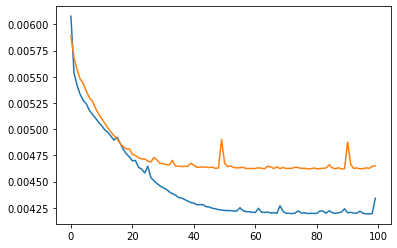

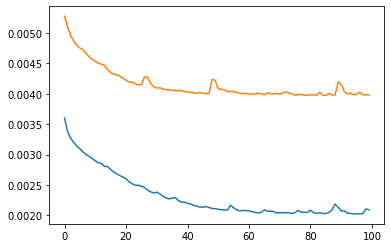

In [6]:
# Function to create 4D interactive scatter plots
def create_4D_scatter_plot(ax, df, acc_column, acc_range, title):
    filtered_df = df[(df[str(acc_column)] > acc_range[0]) & (df[str(acc_column)] <= acc_range[1])]
    ax.scatter(filtered_df['x_b'], filtered_df['QQ'], filtered_df['t'], c=filtered_df[str(acc_column)], cmap='viridis')
    ax.set_xlabel('x_b')
    ax.set_ylabel('QQ')
    ax.set_zlabel('t')
    ax.set_title(title)

def run_replica(i):
    replica_number = i
    tempdf = GenerateReplicaData(df)
    tempdf.to_csv('Replica_Data/rep_data' + str(replica_number) + '.csv')

    trainKin, testKin, trainY, testY, trainYerr, testYerr = split_data(tempdf[['QQ', 'x_b', 't', 'phi_x', 'k']],
                                                                       tempdf['F'], tempdf['errF'], split=0.1)

    tfModel = DNNmodel()
    history = tfModel.fit(trainKin, trainY, validation_data=(testKin, testY), epochs=EPOCHS, callbacks=[modify_LR],
                          batch_size=300, verbose=2)
    
    tfModel.save('DNNmodels/' + 'model' + str(replica_number) + '.h5', save_format='h5')

    tempX = df[['QQ', 'x_b', 't', 'phi_x', 'k']]

#     PredictedCFFs = np.array(tf.keras.backend.function(tfModel.layers[0].input, tfModel.layers[5].output)(tempX))
#     PredictedFs = np.array(tf.keras.backend.function(tfModel.layers[0].input, tfModel.layers[7].output)(tempX))
    PredictedCFFs = np.array(tf.keras.backend.function(tfModel.get_layer(name='input_layer').input, tfModel.get_layer(name='cff_output_layer').output)(tempX))
    PredictedFs = np.array(tf.keras.backend.function(tfModel.get_layer(name='input_layer').input, tfModel.get_layer(name='TotalFLayer').output)(tempX))

# name='input_layer'

    replicaResultsdf = GenerateReplicaResults(df, tfModel)
    replicaResultsdf.to_csv('Replica_Results/rep_result' + str(replica_number) + '.csv')
    
    replicaProjectiondf = GenerateProjections(grid_df, tfModel)
    replicaProjectiondf.to_csv('Projections_for_Improve_Model/Proj_result' + str(replica_number) + '.csv')

    tempdf = pd.DataFrame()
    tempdf["Train_Loss"] = history.history['loss'][-100:]
    tempdf["Val_Loss"] = history.history['val_loss'][-100:]
    tempdf.to_csv('Losses_CSVs/' + 'reploss_' + str(replica_number) + '.csv')
    
    plt.figure(1)
    plt.plot(history.history['loss'])
    plt.savefig('Losses_Plots/' + 'train_loss' + str(replica_number) + '.pdf')

    plt.figure(2)
    plt.plot(history.history['val_loss'])
    plt.savefig('Losses_Plots/' + 'val_loss' + str(replica_number) + '.pdf')

    # Create 4D interactive scatter plots based on accuracy ranges
    org_file = data_file
    rep_dat_file = 'Replica_Data/rep_data' + str(replica_number) + '.csv'
    rep_file = 'Replica_Results/rep_result' + str(replica_number) + '.csv'
    org_df = pd.read_csv(org_file, dtype=np.float64)
    rep_dat_df = pd.read_csv(rep_dat_file, dtype=np.float64)
    rep_df = pd.read_csv(rep_file, dtype=np.float64)
    
    org_sliced = org_df
    rep_dat_sliced = rep_dat_df
    rep_sliced = rep_df

    # Create subplots for loss plots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.savefig('Losses_Plots/' + 'loss_plots' + str(replica_number) + '.pdf')
    plt.close()

    # Create a single figure for 4D interactive scatter plots
    fig = plt.figure(figsize=(20, 25))
    
    limit_1 = 50
    limit_2 = 75
 
    # Scatter plot for accuracy > limit_2
    ax1 = fig.add_subplot(4,3,1, projection='3d')
    create_4D_scatter_plot(ax1, rep_sliced, 'Acc_ReH', (limit_2, 100), f'ReH Accuracy > {limit_2}')

    # Scatter plot for limit_1 < accuracy <= limit_2
    ax2 = fig.add_subplot(4,3,2, projection='3d')
    create_4D_scatter_plot(ax2, rep_sliced, 'Acc_ReH', (limit_1, limit_2), f'{limit_1} < ReH Accuracy <= {limit_2}')

    # Scatter plot for 0 < accuracy <= limit_1
    ax3 = fig.add_subplot(4,3,3, projection='3d')
    create_4D_scatter_plot(ax3, rep_sliced, 'Acc_ReH', (0, limit_1), f'0 < ReH Accuracy <= {limit_1}')
    

    # Scatter plot for accuracy > limit_2
    ax4 = fig.add_subplot(4,3,4, projection='3d')
    create_4D_scatter_plot(ax4, rep_sliced, 'Acc_ReE', (limit_2, 100), f'ReE Accuracy > {limit_2}')

    # Scatter plot for limit_1 < accuracy <= limit_2
    ax5 = fig.add_subplot(4,3,5, projection='3d')
    create_4D_scatter_plot(ax5, rep_sliced, 'Acc_ReE', (limit_1, limit_2), f'{limit_1} < ReE Accuracy <= {limit_2}')

    # Scatter plot for 0 < accuracy <= limit_1
    ax6 = fig.add_subplot(4,3,6, projection='3d')
    create_4D_scatter_plot(ax6, rep_sliced, 'Acc_ReE', (0, limit_1), f'0 < ReE Accuracy <= {limit_1}')

    
    # Scatter plot for accuracy > limit_2
    ax7 = fig.add_subplot(4,3,7, projection='3d')
    create_4D_scatter_plot(ax7, rep_sliced, 'Acc_ReHt', (limit_2, 100), f'ReHt Accuracy > {limit_2}')

    # Scatter plot for limit_1 < accuracy <= limit_2
    ax8 = fig.add_subplot(4,3,8, projection='3d')
    create_4D_scatter_plot(ax8, rep_sliced, 'Acc_ReHt', (limit_1, limit_2), f'{limit_1} < ReHt Accuracy <= {limit_2}')

    # Scatter plot for 0 < accuracy <= limit_1
    ax9 = fig.add_subplot(4,3,9, projection='3d')
    create_4D_scatter_plot(ax9, rep_sliced, 'Acc_ReHt', (0, limit_1), f'0 < ReHt Accuracy <= {limit_1}')
    

    # Scatter plot for accuracy > limit_2
    ax10 = fig.add_subplot(4,3,10, projection='3d')
    create_4D_scatter_plot(ax10, rep_sliced, 'Acc_dvcs', (limit_2, 100), f'dvcs Accuracy > {limit_2}')

    # Scatter plot for limit_1 < accuracy <= limit_2
    ax11 = fig.add_subplot(4,3,11, projection='3d')
    create_4D_scatter_plot(ax11, rep_sliced, 'Acc_dvcs', (limit_1, limit_2), f'{limit_1} < dvcs Accuracy <= {limit_2}')

    # Scatter plot for 0 < accuracy <= limit_1
    ax12 = fig.add_subplot(4,3,12, projection='3d')
    create_4D_scatter_plot(ax12, rep_sliced, 'Acc_dvcs', (0, limit_1), f'0 < dvcs Accuracy <= {limit_1}')
    
    plt.savefig('Replica_Results/kinematics_combined_' + str(replica_number) + '.pdf')
    plt.close()

# Assuming your loop to run replicas is something like this
for i in range(NUM_REPLICAS):
    run_replica(i)